Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/12/20 16:55:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-12-20 16:55:58,112 - sds - INFO - Calling DataFrame.select(cols=('a',))    
INFO:sds:Calling DataFrame.select(cols=('a',))
2022-12-20 16:55:58,142 - sds - INFO - Calling DataFrame.filter(condition=a=2)
INFO:sds:Calling DataFrame.filter(condition=a=2)


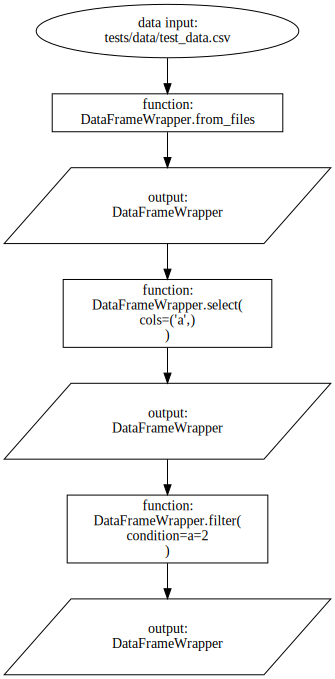

In [1]:
from pyspark.sql import SparkSession
from sds_data_model.dataframe import DataFrameWrapper

spark = (
    SparkSession.builder.master(
        "local",
    )
    .appName(
        "Test context",
    )
    .getOrCreate()
)

dfw = DataFrameWrapper.from_files(
    data_path="tests/data/test_data.csv",
    name="test",
    spark=spark,
)

dfw.call_method("select", "a")

dfw.call_method("filter", "a=2")

dfw.graph

In [2]:
from re import search



In [3]:
dfw.graph.body

['\tdata_path [label="data input:\ntests/data/test_data.csv" shape=oval]\n',
 '\t"DataFrameWrapper.from_files" [label="function:\nDataFrameWrapper.from_files" shape=box]\n',
 '\tDataFrameWrapper [label="output:\nDataFrameWrapper" shape=parallelogram]\n',
 '\tdata_path -> "DataFrameWrapper.from_files"\n',
 '\t"DataFrameWrapper.from_files" -> DataFrameWrapper\n',
 '\t"DataFrameWrapper.select(\ncols=(\'a\',)\n)" [label="function:\nDataFrameWrapper.select(\ncols=(\'a\',)\n)" shape=box]\n',
 '\tDataFrameWrapper_1 [label="output:\nDataFrameWrapper" shape=parallelogram]\n',
 '\tDataFrameWrapper -> "DataFrameWrapper.select(\ncols=(\'a\',)\n)"\n',
 '\t"DataFrameWrapper.select(\ncols=(\'a\',)\n)" -> DataFrameWrapper_1\n',
 '\t"DataFrameWrapper.filter(\ncondition=a=2\n)" [label="function:\nDataFrameWrapper.filter(\ncondition=a=2\n)" shape=box]\n',
 '\tDataFrameWrapper_2 [label="output:\nDataFrameWrapper" shape=parallelogram]\n',
 '\tDataFrameWrapper -> "DataFrameWrapper.filter(\ncondition=a=2\n)"

In [2]:
from dask.array import arange, full, ones
from shapely.geometry import box
from xarray import DataArray

from sds_data_model.constants import BNG_XMAX, BNG_XMIN, BNG_YMAX, BNG_YMIN, CELL_SIZE, BBOXES

lookup_val = 1

main_array = DataArray(
        full([130_000, 70_000], fill_value=255, dtype="uint8"),
        name="main",
        coords={
            "northings": arange(BNG_YMAX - (CELL_SIZE / 2), BNG_YMIN, -CELL_SIZE),
            "eastings": arange(BNG_XMIN + (CELL_SIZE / 2), BNG_XMAX, CELL_SIZE),
        },
    )

centers = [box(*bbox).centroid for bbox in BBOXES]
small_boxes = [
    (int(center.x - 10_000), int(center.y - 10_000), int(center.x + 10_000), int(center.y + 10_000))
    for center in centers
]

for small_box in small_boxes:
    sub_array = DataArray(
        ones([2000, 2000], dtype="uint8") * lookup_val,
        name="sub",
        coords={
            "eastings": arange(
                small_box[0] + (CELL_SIZE / 2), small_box[2], CELL_SIZE
            ),
            "northings": arange(
                small_box[3] - (CELL_SIZE / 2), small_box[1], -CELL_SIZE
            ),
        },
    )

    # update the main array
    main_array = sub_array.combine_first(main_array)

main_array

/home/edfawcetttaylor/repos/sds-data-model/.venv/lib/python3.8/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/edfawcetttaylor/repos/sds-data-model/.venv/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True})

<xarray.DataArray 'sub' (eastings: 70000, northings: 130000)>
dask.array<where, shape=(70000, 130000), dtype=float64, chunksize=(10000, 10000), chunktype=numpy.ndarray>
Coordinates:
  * eastings   (eastings) float64 5.0 15.0 25.0 35.0 ... 7e+05 7e+05 7e+05 7e+05
  * northings  (northings) float64 5.0 15.0 25.0 ... 1.3e+06 1.3e+06 1.3e+06